In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as interp
import moveSTIR as stir
import igraph as ig
import random
import glob
import os

# '#e6194B' Red
cols = np.array(['#A9A9A9', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
        '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', 
        '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#a9a9a9', '#ffffff', '#000000'])

# Set plot properties
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

#  Analysis of pig movement data with MoveSTIR

The analysis pipeline flows as follows

1. Fitting pig movement data using continuous-time movement models (see script `fit_and_predict_ctmm.R`)
    - This analysis is separate from MoveSTIR, but is an essential step to the MoveSTIR analysis
2. Computing the pairwise transmission kernels from the continuous-time movement models (see script `process_transmission_kernels.py`)
    - This can be a memory intensive process. Thus, we perform this analysis in a separate script and save the marginal results. Running `process_transmission_kernels.py` takes ~40 minutes on a single core or ~10 minutes on 8 cores.
3. Analyzing the processed transmission kernels
    - This notebook analyzes the marginal transmission kernels to explore individual, temporal, and spatial variation in transmission risk.

## Load the processed transmission kernels directly

See the script `process_transmission_kernels.py` for the processing of the transmission kernels

`fois_direct`, `fois_indirect` contain all pairwise combinations of the force of infection felt by host $i$ from host $j$ over the time that their collaring overlapped.

The term `fois_direct[(i, j)]` contains the tuple with 
1. The FOI trajectory ($i \leftarrow j$)
2. The time range of the trajectory (in minutes)
3. The time step of the trajectory (in minutes)
4. And the time stamps in Unix time converted to minutes

In [2]:
# Load host keys
host_keys = pd.read_pickle("../results/host_keys.pkl")

In [3]:
# Make an identical matrix using the other set of simulations
ind_foi_dt = {}
ind_dep_dt = {}
fois_direct = {}
fois_indirect = {}
dd = 10 # Distance decay parameter in meters. Choose either 1m or 10m
path = "../results/trans_kernels/"

for i, h1_nm in enumerate(host_keys):
    
    ind_foi_dt[h1_nm] = []
    
    for j, h2_nm in enumerate(host_keys):
        if i != j:
            fnm = os.path.join(path, "marginal_fois_step5_use_ctmm_True_dd{2}-{0}_{1}.pkl".format(h1_nm, h2_nm, dd))
            direct, indirect, _, _ = pd.read_pickle(fnm)
            
            fois_direct[(i, j)] = direct
            fois_indirect[(i, j)] = indirect
            
            foi, time_range, deltat, time = direct
            foi_id, time_range, deltat, time = indirect
            
            if len(time) > 0:
                nm = str(h1_nm) + "_" + str(h2_nm)
                ind_foi_dt[h1_nm].append(pd.DataFrame({"time": time, nm: foi + foi_id}))

Join the FOI vectors for each pairwise contact

In [4]:
from functools import reduce

chaz_all = {}
cdep_all = {}
for h_nm in host_keys:
    
    # Join all FOIs for each host
    df_joined = reduce(lambda left,right: pd.merge(left,right, on='time', how="outer"), ind_foi_dt[h_nm]).set_index("time")

    # Sum fois across all temporal pairwise interactions
    chaz_all[h_nm] = df_joined.sum(axis=1, skipna=True).sort_index()

`chaz_all` is a dictionary with key words being host ids, that looks up a Series with index `time` (the Unix time stamp in minutes) and values being the FOI experienced by the given host from all other hosts at that moment in time.

## Make Figure 4 in the main text

Examine the temporal and individual heterogeneity in force of infection among individual pigs

/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator


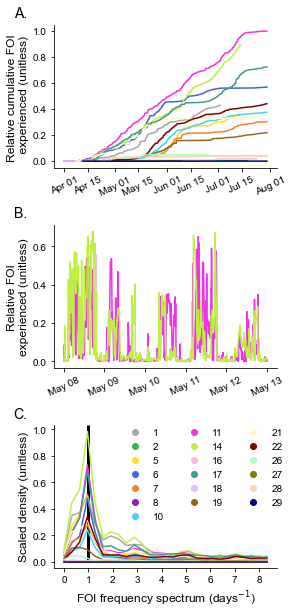

In [5]:
import matplotlib.dates as mdates
import datetime as dtime
import scipy.signal as signal

myFmt = mdates.DateFormatter('%b %d')

fig, axes = plt.subplots(3, 1, figsize=(4, 10))
axes = axes.ravel()

# Make plots
cdats = [chaz_all, chaz_all]

for i, cdat in enumerate(cdats):
    
    ax = axes[i]
    norm_vals = []
    max_vals = []
    avg_vals = []

    for h_nm in host_keys:
        
        chaz = cdat[h_nm]

        # Focus on a specific time window from April to August
        time = chaz.index.values
        datetime = pd.to_datetime(time*60*10**9)[:]
        ind = (datetime > dtime.datetime(2017, 4, 1)) & (datetime < dtime.datetime(2017, 7, 30))
        
        if i == 0:
            
            # Cumulative hazard
            ind = (datetime > dtime.datetime(2017, 4, 1)) & (datetime < dtime.datetime(2017, 7, 30))
            full_cumsum = chaz.values.cumsum()
            x = datetime[ind]
            y = full_cumsum[ind] - np.min(full_cumsum[ind])
        else:
            # Temporal FOI
            ind = (datetime > dtime.datetime(2017, 5, 8)) & (datetime < dtime.datetime(2017, 5, 13))
            full_cumsum = chaz.values
            x = datetime[ind]
            y = full_cumsum[ind]

        norm_vals.append((x, y))
        max_vals.append(np.max(y))

    for j, (x, y) in enumerate(norm_vals):
        

        if i == 1:
            
            # Plot hazard
            if host_keys[j] in [14, 11]:
                ax.plot(x, y / np.max(max_vals), color=cols[j], alpha=1)
        else:
            ax.plot(x, y / np.max(max_vals), color=cols[j])
            
ylabs = ["Relative cumulative FOI \n experienced (unitless)",
         "Relative FOI\nexperienced (unitless)"]
for i, ax in enumerate(axes[:2]):
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylabel(ylabs[i], size=12)

## Compute Welch's periodicity
densities = []

for j, hnm in enumerate(host_keys):
    
    chaz = chaz_all[hnm]
    time = chaz.index.values
    foi = chaz.values
    dt = time[1] - time[0]

    f, dens = signal.periodogram(foi, 1 / dt)
    fw, densw = signal.welch(foi, 1 / dt, nperseg=900)
    ind = fw < 0.006 #0.0025
    
    #if np.max(densw[ind]) < 800:
    
    # Convert to day time units.
    # Dividing by 350 normalizes
    axes[2].plot(fw[ind] * 60 * 24, densw[ind] / 350, color=cols[j])
    densities.append((fw[ind], densw[ind]))
    
ylim = axes[2].get_ylim()
axes[2].vlines(1, 0, ylim[1], color="black", lw=3)
axes[2].set_ylim(ylim)
axes[2].set_ylabel("Scaled density (unitless)", size=12)
axes[2].set_xlabel("FOI frequency spectrum (days$^{-1}$)", size=12)
axes[2].set_xticks(np.arange(0, 9))
#axes[3].set_facecolor("#DCDCDC")

letters = ["A.", "B.", "C."]
for i, ax in enumerate(axes):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.text(-0.15, 1.05, letters[i], size=14, ha='center', transform=ax.transAxes)
    
handles = [plt.Line2D([1], [1], color=cols[i], marker='o', linestyle="", label=list(host_keys)[i]) for i in range(len(host_keys))]
axes[2].legend(loc=(.3, .3), handles=handles, ncol=3, frameon=False)

plt.subplots_adjust(hspace=.4)

#fig.savefig("../results/pigs_foi.pdf", bbox_inches="tight")

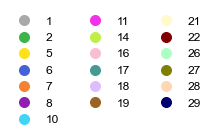

In [6]:
# Make legend for the plot

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
handles = [plt.Line2D([1], [1], color=cols[i], marker='o', markersize=10, linestyle="", label=host_keys[i]) for i in range(len(host_keys))]
ax.legend(loc=(-0.2, -0.1), handles=handles, ncol=3, frameon=False, prop={'size': 12})
for t in ['left', 'right', 'top', 'bottom']:
    ax.spines[t].set_visible(False)

ax.tick_params(labelbottom=None, labelleft=None, bottom=None, left=None)
plt.tight_layout()
#fig.savefig("../results/collar_ids.pdf", bbox_inches="tight")

## Analyze the static contact networks defined by MoveSTIR

Output from MoveSTIR can be represented as a dynamic network, which in turn can be simplified to a weight, directional, static network (with loss of information).  Here, we calculate the weighted, static direct, indirect, and full networks for the pig case study.

In [7]:
# Create weighted, static association matrices from FOI

n = len(host_keys)
average_foi_direct = np.zeros((n, n))
average_foi_indirect = np.zeros((n, n))
average_foi = np.zeros((n, n))

for i, h1_nm in enumerate(host_keys):
    for j, h2_nm in enumerate(host_keys):
        
        if i != j:
            foi, time_range, deltat, time = fois_direct[(i, j)]
            foi_id, time_range, deltat, time = fois_indirect[(i, j)]
            
            # Calculate the average FOI (direct, indirect, and full) for a given i, j pair
            average_foi_direct[i, j] = np.sum(foi*deltat) / time_range
            average_foi_indirect[i, j] = np.sum(foi_id*deltat) / time_range
            average_foi[i, j] = np.sum((foi_id + foi)*deltat) / time_range

## Calculate relative R0 for direct and indirect contact networks. 

**IMPORTANT**:  The absolute values of $R_0$ are not interpretable because we do not know the absolute values of $\beta$, $\lambda$, or $\gamma$.  However, these parameters cancel out when we take ratios of $R_0$ so the relative values of $R_0$ are interpretable.

In [8]:
# Define different transmission matrices
Fdirect = average_foi_direct
Findirect = average_foi_indirect
F = average_foi

# How many direct and indirect connections?
direct_exists = (Fdirect > 0).astype(np.int64)
indirect_exists = (Findirect > 0).astype(np.int64)

# How many more indirect connections exist than direct connections?
print((np.sum(indirect_exists) - np.sum(direct_exists)))

126


In [9]:
# Load the home range overlap association matrix.
Fhr_area = pd.read_csv("../data/home_range_overlaps_area.csv").values

In [10]:
γ = 1 # Rate of leaving the infected class. Value does not matter for the ratio!

# Use MoveSTIR functions to compute R0 from the different static, weighted networks
_, R0_indirect, _, _ = stir.movement_R0_from_avg_foi(Findirect, γ)
_, R0_direct, _, _ = stir.movement_R0_from_avg_foi(Fdirect, γ)
_, R0_full, _, _ = stir.movement_R0_from_avg_foi(F, γ)

# Ratio between full R0 and direct R0
# Ratio between indirect R0 and direct R0
print((R0_full / R0_direct))
print((R0_indirect / R0_direct))
print((R0_full / R0_indirect))

print((R0_direct / R0_full))
print((R0_direct / R0_indirect))

print((R0_indirect / R0_full))
print((R0_indirect / R0_direct))

212.59115838692185
211.62301041263993
1.0045748710047842
0.004703864486123041
0.0047253840593710385
0.9954459631264633
211.62301041263993


In [11]:
# Compare home range overlap network with F network
# Use MoveSTIR functions to compute R0 from the different static, weighted networks
_, R0_hr_area, _, _ = stir.movement_R0_from_avg_foi(Fhr_area, γ)

print(R0_full / R0_hr_area)
print(R0_direct / R0_hr_area)
print(R0_indirect / R0_hr_area)
print(R0_hr_area / R0_indirect)
print(R0_hr_area / R0_full)
print(R0_hr_area / R0_direct)

30.020513201949342
0.14121242590583738
29.88379867786517
0.033462947959848784
0.033310556460942393
7.081529784544707


Test whether the change in $R_0$ between direct and full is due to new connections or because of the strengthening of existing connections.  We can do this by eliminating all of the connections in the full network that don't exist in the direct network and recalculating $R_0$

In [12]:
direct_exists = (Fdirect > 0).astype(np.int64)

# Reduce indirect edges
F_reduced = F * direct_exists

γ = 1 # Rate of leaving the infection class. Value does not matter for the ratio!
_, R0_reduced, _, _ = stir.movement_R0_from_avg_foi(F_reduced, γ)
_, R0_direct, _, _ = stir.movement_R0_from_avg_foi(Fdirect, γ)

# Ratio between indirect and direct.
print((R0_reduced / R0_direct))

212.5909239079118


We can see that even after we remove all of the new edges, $R_0$ on the full network is still over 200 times larger than $R_0$ on the direct network alone. This indicates that strengthening existing edges, not adding new edges, is driving the change in $R_0$.

## Contribution of individual pigs to $R_0$

In [13]:
# Load male, female data
mf_dat = pd.read_csv("../data/pig_info.csv")
sex_ids = {tid: mf_dat[mf_dat.individual_ID == tid].sex.values[0] for tid in host_keys}

Loop through pigs, delete them from the network, and calculate how much $R_0$ changes

In [14]:
nind = F.shape[0]
reduction = []
for i in range(nind):
    Fdel = np.delete(np.delete(F, i, 0), i, 1)
    _, R0_del, _, _ = stir.movement_R0_from_avg_foi(Fdel, γ)
    reduction.append((host_keys[i], 1 - (R0_del / R0_full)))
hosts, red = zip(*reduction)

In [15]:
# Same calculation based on home range overlap
nind = Fhr_area.shape[0]
reduction_hr = []
for i in range(nind):
    Fdel = np.delete(np.delete(Fhr_area, i, 0), i, 1)
    _, R0_del, _, _ = stir.movement_R0_from_avg_foi(Fdel, γ)
    reduction_hr.append((host_keys[i], 1 - (R0_del / R0_hr_area)))
hosts_hr, red_hr = zip(*reduction_hr)

## Plot the networks

In [17]:
average_foi_direct[np.triu_indices_from(average_foi_direct)] = 0 

g_direct = ig.Graph.Weighted_Adjacency(average_foi_direct)
g_indirect = ig.Graph.Weighted_Adjacency(average_foi_indirect)
g_full = ig.Graph.Weighted_Adjacency(average_foi)
g_hr = ig.Graph.Weighted_Adjacency(Fhr_area)

# Set the default layout that approximately maps to space
random.seed(125)
layout = g_full.layout_fruchterman_reingold()

for g in [g_direct, g_indirect, g_full, g_hr]:
    g.vs['id'] = list(host_keys)
    g.vs['sex'] = [sex_ids[tid] for tid in host_keys]
    g.vs['reduction'] = ["{0:.0f}%".format(r) if r >= 1 else "<1%" for r in np.round(100*np.array(red), decimals=0)]
    g.vs['reduction_hr'] = ["{0:.0f}%".format(r) if r >= 1 else "<1%" for r in np.round(100*np.array(red_hr), decimals=0)]
    

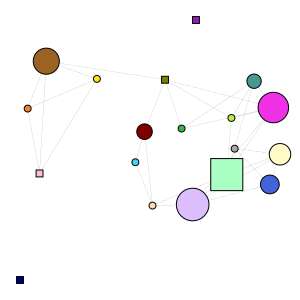

In [18]:
edge_weights = g_direct.get_edge_dataframe().weight.values
sexes = g_direct.get_vertex_dataframe().sex.values
btwn = np.array(g_direct.betweenness())
btwn = (btwn - btwn.mean()) / btwn.std()
btwn = btwn + np.abs(btwn.min())

shape_map = {'M': 'square', 'F': 'circle'}
ig.plot(g_direct, #"../results/direct_network.pdf",
        layout=layout,
        edge_width=0.1,
        bbox=(0, 0, 300, 300),
        edge_arrow_size=0,
        vertex_color=cols, 
        vertex_size=20*np.log(btwn + 1.1) + 5,
        vertex_shape=[shape_map[tsex] for tsex in sexes])

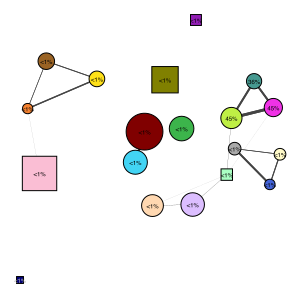

In [19]:
edge_weights = g_full.get_edge_dataframe().weight.values
sexes = g_full.get_vertex_dataframe().sex.values

btwn = np.array(g_full.betweenness())
btwn = (btwn - btwn.mean()) / btwn.std() #(btwn - btwn.min()) / btwn.max()
btwn = btwn + np.abs(btwn.min())

font_colors = np.repeat("black", len(host_keys))
font_colors[-1] = "gray"
ig.plot(g_full, #"../results/full_network.pdf",
        layout=layout,
        edge_width=(30*edge_weights / np.sum(edge_weights)),
        bbox=(0, 0, 300, 300),
        edge_arrow_size=0,
        vertex_label=g_full.get_vertex_dataframe().reduction.values, 
        vertex_label_size=6,
        vertex_label_color=font_colors,
        vertex_color=cols, 
        vertex_size=20*np.log(btwn + 1.1) + 5,
        vertex_shape=[shape_map[tsex] for tsex in sexes], 
        edge_curved=False)

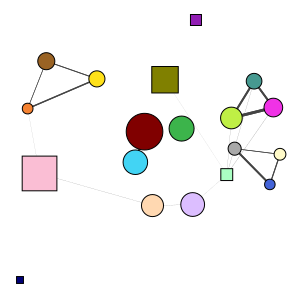

In [20]:
edge_weights = g_indirect.get_edge_dataframe().weight.values
sexes = g_indirect.get_vertex_dataframe().sex.values

btwn = np.array(g_indirect.betweenness())
btwn = (btwn - btwn.mean()) / btwn.std() #(btwn - btwn.min()) / btwn.max()
btwn = btwn + np.abs(btwn.min())

font_colors = np.repeat("black", len(host_keys))
font_colors[-1] = "gray"
ig.plot(g_full, #"../results/indirect_network.pdf",
        layout=layout,
        edge_width=(30*edge_weights / np.sum(edge_weights)),
        bbox=(0, 0, 300, 300),
        edge_arrow_size=0,
        vertex_label_size=6,
        vertex_label_color=font_colors,
        vertex_color=cols, 
        vertex_size=20*np.log(btwn + 1.1) + 5,
        vertex_shape=[shape_map[tsex] for tsex in sexes], 
        edge_curved=False)

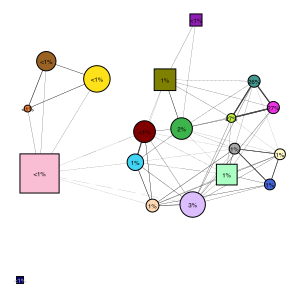

In [21]:
edge_weights = g_hr.get_edge_dataframe().weight.values
sexes = g_hr.get_vertex_dataframe().sex.values
btwn_hr = np.array(g_hr.betweenness())
btwn_hr = (btwn_hr - btwn_hr.mean()) / btwn_hr.std()
btwn_hr = btwn_hr + np.abs(btwn_hr.min())

ig.plot(g_hr, #"../results/full_network_hr.pdf",
        layout=layout,
        bbox=(0, 0, 300, 300),
        edge_width=(30*edge_weights / np.sum(edge_weights)),
        vertex_color=cols,
        vertex_label=g_hr.get_vertex_dataframe().reduction_hr.values,
        vertex_label_size=6,
        edge_arrow_size=0.001,
        vertex_size=20*np.log(btwn_hr + 1.1) + 5,
        vertex_shape=[shape_map[tsex] for tsex in sexes],
        edge_curved=False,
        vertex_label_color=font_colors)

### Calculate some summary network metrics

In [22]:
print("Mean degree: full {0:.3}, direct {1:.3}, indirect {2:.3}, home range {3:.3}".format(np.mean(np.array(g_full.degree())), np.mean(np.array(g_direct.degree())), np.mean(np.array(g_indirect.degree())), np.mean(np.array(g_hr.degree()))))
print("Transitivity: full {0:.3}, direct {1:.3}, indirect {2:.3}, home range {3:.3}".format(g_full.transitivity_undirected(), g_direct.transitivity_undirected(), g_indirect.transitivity_undirected(), g_hr.transitivity_undirected()))

Mean degree: full 20.1, direct 3.37, indirect 20.0, home range 21.1
Transitivity: full 0.751, direct 0.51, indirect 0.751, home range 0.764


### Calculate correlations between weighted adjacency matrices

Note that Mantel tests are applicable to symmetric matrices. The full and indirect network are not necessarily symmetric. However, they are close so we will use the Mantel test as an approximation. 

In [23]:
from skbio import DistanceMatrix
from skbio.stats.distance import mantel

In [24]:
def make_symmetric(mat):
    # Force matrix to be symmetrical
    lt = np.tril(mat, k=-1)
    return(lt.T + lt)

In [25]:
fullmat = DistanceMatrix(make_symmetric(average_foi))
directmat = DistanceMatrix(make_symmetric(average_foi_direct))
indirectmat = DistanceMatrix(make_symmetric(average_foi_indirect))
hrmat = DistanceMatrix(make_symmetric(Fhr_area))
all_mats = [fullmat, directmat, indirectmat, hrmat]

In [29]:
corrmat = np.empty((4, 4))
corrmat_long = np.empty((4, 4))

for i, m1 in enumerate(all_mats):
    for j, m2 in enumerate(all_mats):
        corrmat[i, j] = mantel(m1, m2)[0]
        
        # Calculate the correlation coefficient if we just flatten the matrices
        corrmat_long[i, j] = stats.pearsonr(m1.to_data_frame().values.ravel(), y=m2.to_data_frame().values.ravel())[0]

In [27]:
corrmat

array([[1.        , 0.92072652, 0.99999844, 0.89346718],
       [0.92072652, 1.        , 0.92003606, 0.80393184],
       [0.99999844, 0.92003606, 1.        , 0.89355044],
       [0.89346718, 0.80393184, 0.89355044, 1.        ]])

In [28]:
corrmat_long

array([[1.        , 0.92088087, 0.99999845, 0.89272419],
       [0.92088087, 1.        , 0.92019201, 0.80322404],
       [0.99999845, 0.92019201, 1.        , 0.89280814],
       [0.89272419, 0.80322404, 0.89280814, 1.        ]])

### Visualize the networks for different metrics of home range overlap

We examine the Bhattacharyya Coefficient (BA), Volume of Intersection (VI), and proportion of home range overlap (HR).  These metrics are defined in the R package `adehabitatHR` and we calculate them in the script `calculate_hr_area.R`.  Note that we can not compare the $R_0$ estimates using these metrics directly to the direct + indirect network from MoveSTIR as these metrics would need to be scaled by constant of proportionality to be directly comparable.  However, we can explore how the relative individual-level contributions to $R_0$ compare between the direct and indirect network defined by MoveSTIR and those predicted by these home-range overlap metrics

In [30]:
# Load the home range overlap association matrix.
methods = ["HR", "BA", "VI"]

for method in methods:

    Fhr_overlap = pd.read_csv("../data/home_range_overlaps_{0}.csv".format(method)).values
    _, R0_hr_overlap, _, _ = stir.movement_R0_from_avg_foi(Fhr_overlap, γ)

    # Remove individuals
    nind = Fhr_overlap.shape[0]
    reduction_hr = []
    for i in range(nind):
        Fdel = np.delete(np.delete(Fhr_overlap, i, 0), i, 1)
        _, R0_del, _, _ = stir.movement_R0_from_avg_foi(Fdel, γ)
        reduction_hr.append((host_keys[i], 1 - (R0_del / R0_hr_overlap)))
    hosts_hr, red_hr = zip(*reduction_hr)

    # Build and plot network
    g_hr_overlap = ig.Graph.Weighted_Adjacency(Fhr_overlap)

    for g in [g_hr_overlap]:
        g.vs['id'] = list(host_keys)
        g.vs['sex'] = [sex_ids[tid] for tid in host_keys]
        g.vs['reduction_hr'] = ["{0:.0f}%".format(r) if r >= 1 else "<1%" for r in np.round(100*np.array(red_hr), decimals=0)]

    edge_weights = g_hr.get_edge_dataframe().weight.values
    sexes = g_hr.get_vertex_dataframe().sex.values
    btwn_hr = np.array(g_hr.betweenness())
    btwn_hr = (btwn_hr - btwn_hr.mean()) / btwn_hr.std()
    btwn_hr = btwn_hr + np.abs(btwn_hr.min())

    ig.plot(g_hr_overlap, #"../results/full_network_{0}_base.pdf".format(method),
            layout=layout,
            bbox=(0, 0, 300, 300),
            edge_width=(30*edge_weights / np.sum(edge_weights)),
            vertex_color=cols,
            vertex_label=g_hr_overlap.get_vertex_dataframe().reduction_hr.values,
            vertex_label_size=6,
            edge_arrow_size=0.001,
            vertex_size=20*np.log(btwn_hr + 1.1) + 5,
            vertex_shape=[shape_map[tsex] for tsex in sexes],
            edge_curved=False,
            vertex_label_color=font_colors)

## What is the spatial distribution of average potential force of infection on the landscape?

To answer this question, we divide the landscape into 15m by 15m grid cells. For each grid cell, we calculate the the total cumulative FOI experienced by pigs in that grid cell divided by the total pig time spent in the grid cell.

In [31]:
# Load the fitted CTMMs for each pig
path = "../data/ctmm_data/"
all_fitted = {hid: (pd.read_csv(os.path.join(path, "traj_{0}.csv".format(hid))) 
                      .assign(time=lambda x: x.time_s / 60.))
                    for hid in host_keys}

In [32]:
# Define some preliminary parameters for gridding the landscape
all_trajs_df = pd.concat(all_fitted)
buffer = 30

minx = all_trajs_df.x.min() - buffer
maxx = all_trajs_df.x.max() + buffer
miny = all_trajs_df.y.min() - buffer
maxy = all_trajs_df.y.max() + buffer

binsx = np.int64(np.floor((maxx - minx) / 15))
binsy = np.int64(np.floor((maxy - miny) / 15))

xbounds = stir.set_discretized_values(minx, maxx, binsx)
ybounds = stir.set_discretized_values(miny, maxy, binsy)

In [33]:
# Calculate the spatial risk for each host in all grids.
all_sfois = []
for hnm in host_keys:

    foi_dt = pd.DataFrame(chaz_all[hnm], columns=["foi"]).join(all_fitted[hnm].set_index("time"))
    deltat = foi_dt.index[1] - foi_dt.index[0]

    spatial_foi, grids = stir.calculate_spatial_risk(foi_dt, foi_dt.foi.values, deltat, 
                                                     xbounds['bnd'], ybounds['bnd'], 
                                                     calc="cumulative_w_time")
    
    inarea = spatial_foi[(spatial_foi.x != -1) & (spatial_foi.y != -1)]
    all_sfois.append(inarea)
    
all_sfois_df = pd.concat(all_sfois)

In [34]:
all_sfois_df = all_sfois_df.assign(location=lambda x:[(tx, ty) for tx, ty in zip(x.x, x.y)])

In [35]:
# Compute average FOI by location
def avg_foi(x):
    
    names = {'avg_foi': x.risk.sum() / x.time_in_area.sum()}
    return(pd.Series(names, index=['avg_foi']))

spatial_map = all_sfois_df.groupby("location").apply(avg_foi).reset_index()
spatial_map = spatial_map.assign(x=lambda x: [t[0] for t in x.location], 
                                 y=lambda x: [t[1] for t in x.location])

## Make a map of the average FOI and movement trajectories

/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


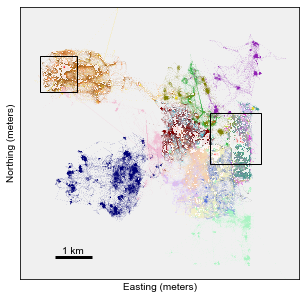

In [36]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define a custom color pallette so that FOI close to 0 is transparent
bwr = cm.get_cmap("bwr", 400)
bwr_colors = bwr(range(400))[200:, :]
ramp = 1
bwr_colors[:ramp, 3] = 0
bwr_colors[ramp:, 3] = 0.9
newmap = ListedColormap([col for col in bwr_colors])

# Set up X an Y values for plotting
X = xbounds['y']
Y = ybounds['y']
XX, YY = np.meshgrid(X, Y)
Z = XX*YY*0.0
maxval = np.max(spatial_map.avg_foi.values)
Z[spatial_map.y.values, spatial_map.x.values] = spatial_map.avg_foi.values # np.where(spatial_map.avg_foi > maxval / 2, maxval, 0)
norm = TwoSlopeNorm(vmin=-0.000001, vcenter=0, vmax=maxval)

# Plot the Average FOI
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pcol = ax.pcolormesh(XX, YY, Z, cmap=newmap, vmin=0, vmax=maxval)

# Plot the hosts continuous time movement trajectories
for i, hnm in enumerate(host_keys):
    ttraj = all_fitted[hnm]
    
    # Set gray color to help with visualization
    if hnm == 1:
        tcol = '#606060'
    else:
        tcol = cols[i]
        
    ax.plot(ttraj.x, ttraj.y, 'o', color=tcol, ms=1, alpha=.1, zorder=-1, mew=0)

# Format plot
ylim = ax.get_ylim()
xlim = ax.get_xlim()
diff = (ylim[1] - ylim[0]) - (xlim[1] - xlim[0])
xlower = xlim[0] - (diff / 2)
xupper = xlim[1] + (diff / 2)
ax.set_xlim((xlower, xupper))
ax.ticklabel_format(scilimits=(-5, 9))
ax.tick_params(labelbottom=None, labelleft=None, bottom=None, left=None)
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
ax.hlines(3002000, 478000, 479000, linewidth=3, color='black')
#ax.vlines(478000, 3002000, 3003000, linewidth=3, color='black')
ax.text(478500, 3002100, "1 km", ha='center')
ylim = ax.get_ylim()
xlim = ax.get_xlim()

# Add area rectangles
p = plt.Rectangle((482200.0, 3004600.0), 1400.0, 1400.0, fill=False)
ax.add_patch(p)

p1 = plt.Rectangle((477600, 3006600), 1000.0, 1000.0, fill=False)
ax.add_patch(p1)

ax.set_facecolor("#F0F0F0")

#fig.savefig("../results/spatial_map.jpg", bbox_inches="tight", dpi=500)

## Make subplots

/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


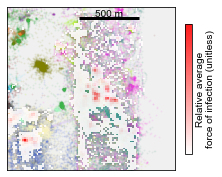

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
pcol = ax.pcolormesh(XX, YY, Z, cmap=newmap, vmin=0, vmax=maxval)#, norm=norm, alpha=0.9)

for i, hnm in enumerate(host_keys):
    ttraj = all_fitted[hnm]
    
    if hnm == 1:
        tcol = '#606060'
    else:
        tcol = cols[i]
    ax.plot(ttraj.x, ttraj.y, 'o', color=tcol, ms=1.8, alpha=.1, zorder=-1, mew=0)

# Trim the plot to the appropriate bounds
xlower = 482200
xupper = 483600
ylower = 3004600
yupper = 3006000

ylim = ax.set_ylim((ylower, yupper))
xlim = ax.set_xlim((xlower, xupper))
ax.ticklabel_format(scilimits=(-5, 9))
ax.tick_params(labelbottom=None, labelleft=None, bottom=None, left=None)
ax.hlines(3005900, 482800, 483300, linewidth=3, color='black')
ax.text(483050, 3005900, "500 m", ha='center', va='bottom')
ylim = ax.get_ylim()
xlim = ax.get_xlim()

cax = fig.add_axes([.95, .2, 0.03, 0.6])

cbar = fig.colorbar(pcol, cax=cax, orientation='vertical')
cbar.set_label("Relative average\nforce of infection (unitless)")
cbar.ax.tick_params(axis='y', right=None, labelright=None)
ax.set_facecolor("#F0F0F0")

#fig.savefig("../results/spatial_map_small.jpg", bbox_inches="tight", dpi=500)

/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


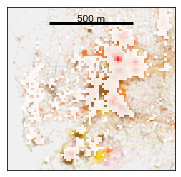

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
pcol = ax.pcolormesh(XX, YY, Z, cmap=newmap, vmin=0, vmax=maxval)#, norm=norm, alpha=0.9)

for i, hnm in enumerate(host_keys):
    ttraj = all_fitted[hnm]
    
    if hnm == 1:
        tcol = '#606060'
    else:
        tcol = cols[i]
    ax.plot(ttraj.x, ttraj.y, 'o', color=tcol, ms=1.8, alpha=.1, zorder=-1, mew=0)

# Trim the plot the appropriate bounds    
xlower = 477600
xupper = 478600
ylower = 3006600
yupper = 3007600

ylim = ax.set_ylim((ylower, yupper))
xlim = ax.set_xlim((xlower, xupper))
ax.ticklabel_format(scilimits=(-5, 9))
ax.tick_params(labelbottom=None, labelleft=None, bottom=None, left=None)
#ax.set_xlabel("Easting (meters)")
#ax.set_ylabel("Northing (meters)")
ax.hlines(3007500, 477850, 478350, linewidth=3, color='black')
#ax.vlines(478000, 3002000, 3003000, linewidth=3, color='black')
ax.text(478100, 3007500, "500 m", ha='center', va='bottom')
ylim = ax.get_ylim()
xlim = ax.get_xlim()

ax.set_facecolor("#F0F0F0")

# cax = fig.add_axes([.95, .2, 0.03, 0.6])

# cbar = fig.colorbar(pcol, cax=cax, orientation='vertical')
# cbar.set_label("Relative average\nforce of infection (unitless)")
# cbar.ax.tick_params(axis='y', right=None, labelright=None)

#fig.savefig("../results/spatial_map_small2.jpg", bbox_inches="tight", dpi=500)

## Save the FOI grids to a raster for GIS analysis

We use this raster file to compute how FOI is distributed within a pig's home range (defined as the 95% utilization distribution). See the script `calculate_hr_area.R`

In [39]:
# Save FOI grid to raster
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin

driver = "GTiff"
Znew = Z[np.newaxis, ::-1, :]
dim = Znew.shape
height = dim[1]
width = dim[2]
dtype = Znew.dtype
crs = CRS.from_proj4("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
transform = from_origin(X[0], Y[-1], X[1] - X[0], Y[1] - Y[0])
count = 1 

with rasterio.open("../data/foi_raster.tif", "w",
                   driver=driver,
                   height=height,
                   width=width,
                   dtype=dtype,
                   crs=crs,
                   transform=transform,
                   count=count) as fout:
    fout.write(Znew)